In [20]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import sin, asin, floor, sqrt, pi
from qiskit.quantum_info import Statevector

def Z_f(target_strings: list[str], n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n, name="Z_f")
    for s in target_strings:
        if len(s) != n or set(s) - {"0","1"}:
            raise ValueError(f"Invalid bitstring: {s}")

    for s in target_strings:
        # Mask zeros so |s> -> |11..1>
        for i, bit in enumerate(reversed(s)):
            if bit == '0':
                qc.x(i)

        if n == 1:
            qc.z(0)                # no H wrappers
        elif n == 2:
            qc.cz(0, 1)            # no H wrappers
        else:
            qc.h(n-1)              # H–MCX–H only for n>=3
            qc.mcx(list(range(n-1)), n-1)
            qc.h(n-1)

        # Unmask
        for i, bit in enumerate(reversed(s)):
            if bit == '0':
                qc.x(i)
    return qc


def Z_or(n: int) -> QuantumCircuit:
    """
    Implements (up to a global phase) the reflection about |0...0>:
        R0 = 2|0...0><0...0| - I
    i.e., phase -1 on |0...0>, +1 elsewhere.
    """
    qc = QuantumCircuit(n, name="Z_or")
    qc.x(range(n))

    if n == 1:
        qc.z(0)
    elif n == 2:
        qc.cz(0, 1)
    else:
        qc.h(n-1)
        qc.mcx(list(range(n-1)), n-1)  # controls: 0..n-2, target: n-1
        qc.h(n-1)

    qc.x(range(n))
    return qc

def grovers_operation(target_strings: list[str],n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n, name="Grovers_op")
    qc.append(Z_f(target_strings, n), range(n))
    qc.h(range(n))
    qc.append(Z_or(n), range(n))
    qc.h(range(n))
    return qc

def run_grovers(target_strings: list[str], num_shots: int) -> plot_histogram:
    n = len(target_strings[0])
    s = len(target_strings)
    N = 2 ** n
    theta = asin(sqrt(s/N))
    r_est = floor((pi/(4*theta)) - 0.5)
    P = lambda r: sin((2*r+1)*theta)**2
    num_iterations = max(0, max([r_est, r_est+1], key=P))

    qc0 = grovers_operation(target_strings, n)#.to_instruction()
    qc = QuantumCircuit(n)
    qc.h(range(n))
    for i in range(num_iterations):
        qc.append(qc0, range(n))
    qc.measure_all()
    # Pretty matplotlib circuit visualization
    qc.draw(output="mpl")
    display(qc.draw(output="mpl"))


    # Run on simulator
    sim = Aer.get_backend("aer_simulator")
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots = num_shots).result()
    counts = result.get_counts()
    return plot_histogram(counts, title="Target: "+ ", ".join(target_strings))

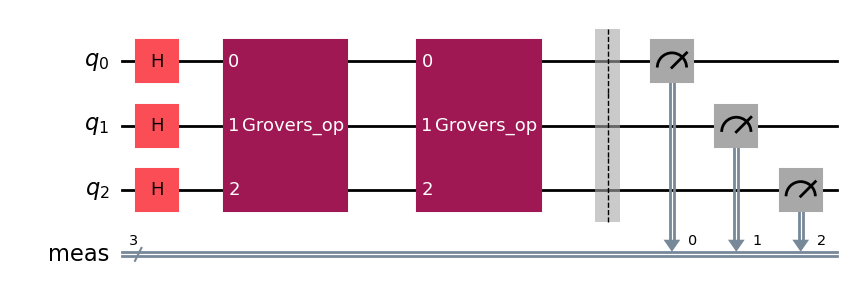

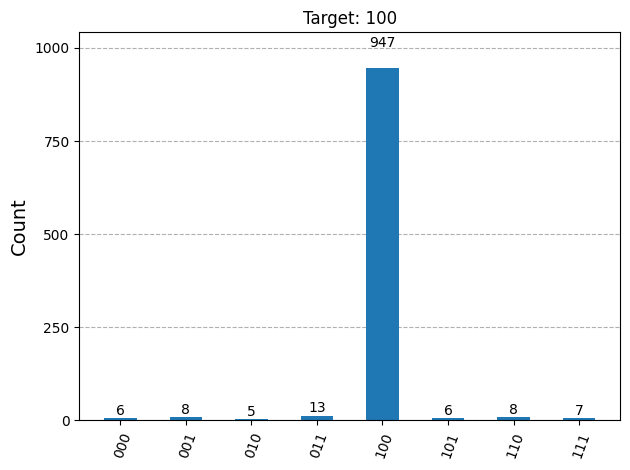

In [21]:
target_strings = ["100"]
shots = 1000
run_grovers(target_strings, shots)

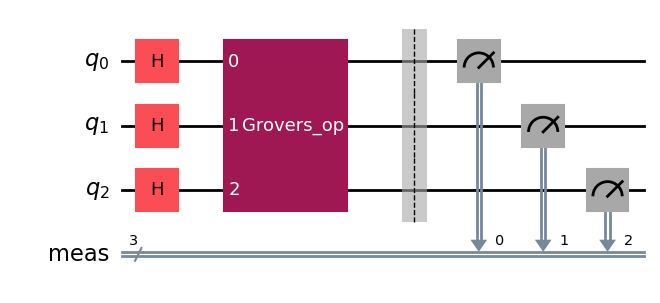

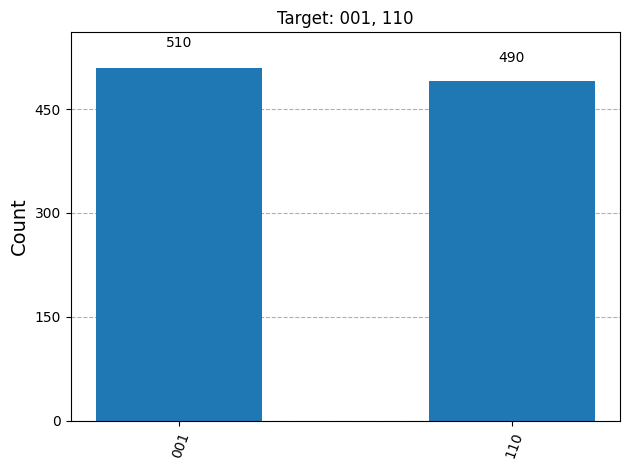

In [22]:
target_strings = ["001", "110"]
shots = 1000
run_grovers(target_strings, shots)

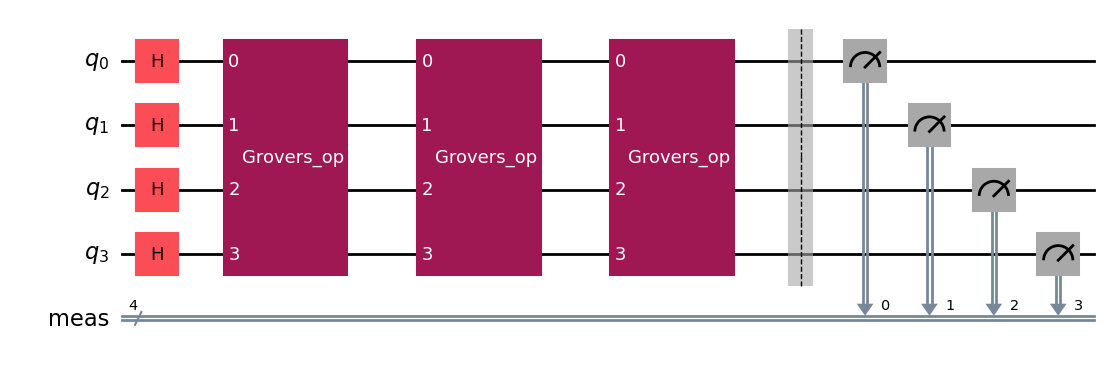

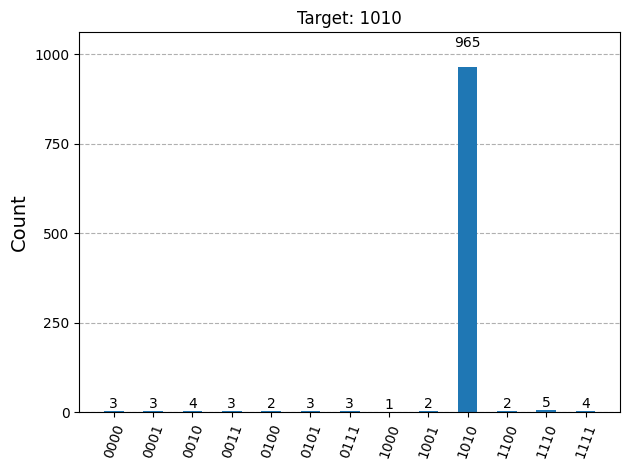

In [23]:
target_strings = ["1010"]
shots = 1000
run_grovers(target_strings, shots)

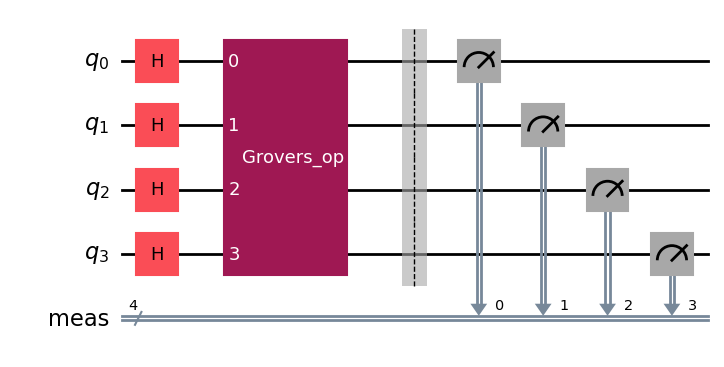

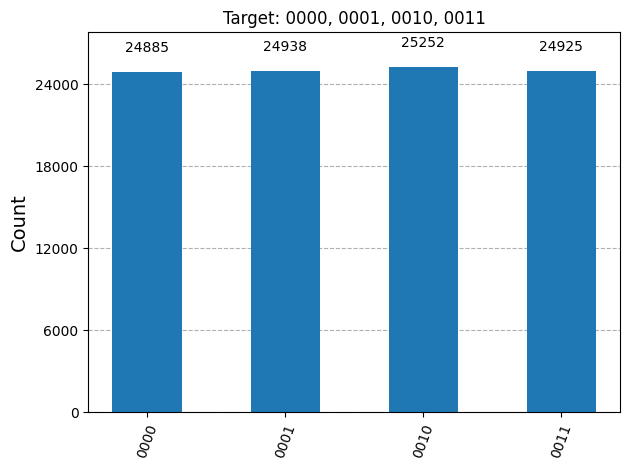

In [24]:
target_strings = ["0000", "0001", "0010", "0011"]
shots = 100000
run_grovers(target_strings, shots)

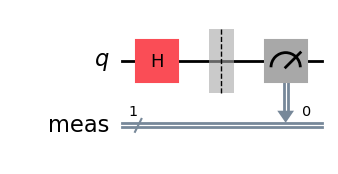

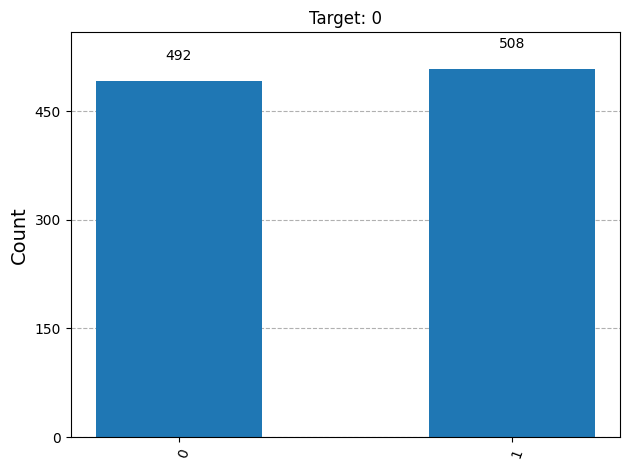

In [25]:
target_strings = ["0"]
shots = 1000
run_grovers(target_strings, shots)

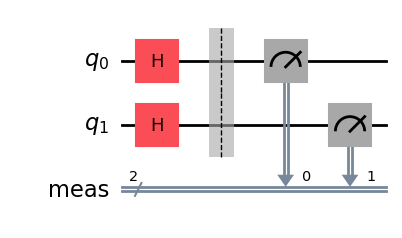

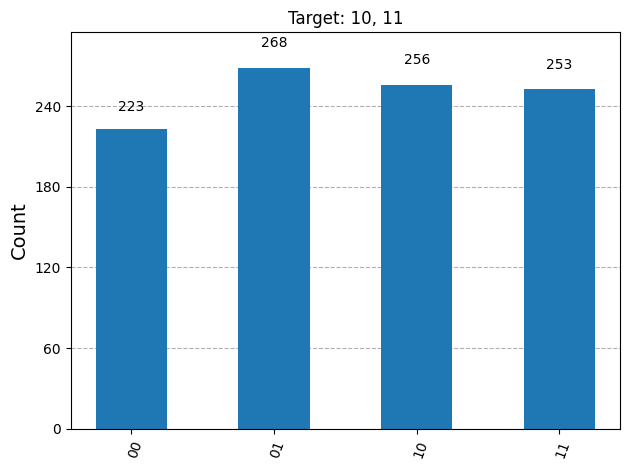

In [26]:
target_strings = ["10","11"]
shots = 1000
run_grovers(target_strings, shots)

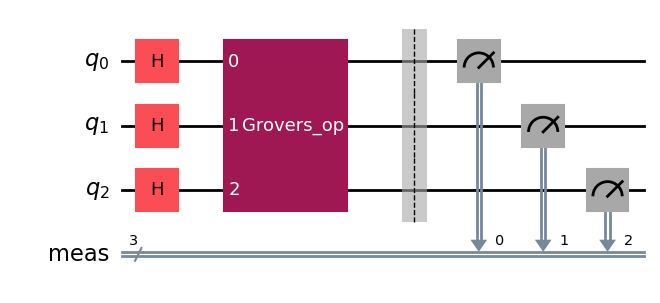

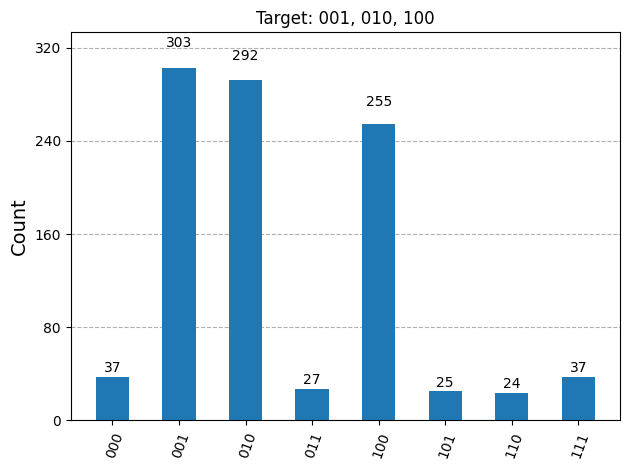

In [27]:
target_strings = ["001","010","100"]
shots = 1000
run_grovers(target_strings, shots)

# Grover’s Algorithm – Summary

Grover’s algorithm provides a quadratic speedup for searching an unstructured database.  
Classically, finding one marked item among $N$ possibilities takes $O(N)$ queries,  
while Grover’s algorithm finds it in $O(\sqrt{N/M})$ iterations, where $M$ is the number of marked states.  

The key parameters are  

$$
\theta = \arcsin\!\sqrt{\tfrac{M}{N}}, \qquad
r^* \approx \frac{\pi}{4\theta} - \tfrac{1}{2},
$$

where $r^*$ is the optimal number of Grover iterations.  

---

## Case Studies

- **["100"]**  
  Setup: $n=3$, $M=1$.  
  Result: After 2 iterations, nearly all measurements collapse to `"100"`.  
  *This is the canonical single-solution case.*

- **["001", "110"]**  
  Setup: $n=3$, $M=2$.  
  Result: A single iteration splits probability ~50/50 between `"001"` and `"110"`.  
  *Perfect two-solution amplification.*

- **["1010"]**  
  Setup: $n=4$, $M=1$.  
  Result: Nearly all outcomes are `"1010"`.  
  *Demonstrates scalability to larger $n$.*

- **["0000","0001","0010","0011"]**  
  Setup: $n=4$, $M=4=N/4$.  
  Result: One iteration yields only the four marked states, equally distributed.  
  *Special case where Grover is exact.*

- **["0"]**  
  Setup: $n=1$, $M/N=1/2$.  
  Result: Outcomes remain 50–50 between `"0"` and `"1"`.  
  *No amplification possible when half the space is marked.*

- **["10","11"]**  
  Setup: $n=2$, $M/N=1/2$.  
  Result: Same limitation: uniform distribution, no speedup.  

- **["001","010","100"]**  
  Setup: $n=3$, $M=3$.  
  Result: Probability is amplified for all three marked states, with some residual weight on others.  
  *Illustrates multi-solution oscillatory behavior.*

---

## Conclusions

- Grover’s algorithm works best when $M \ll N$.  
- For $M/N = 1/4$, it is **exact** in one iteration.  
- For $M/N = 1/2$, Grover’s provides **no advantage**.  
- With multiple solutions, probability is shared among them.  
- Results confirm the quadratic speedup and the known edge cases.
